# Tutorial #2 - Basic - Generating fingerprints and running multiple jobs

This tutorial will cover: 
* Running multiple jobs sequentially vs in parallel
* Generate different flavors of IFP and convert them to RDKit-like objects and then compute Tanimoto similarity
* Plotting heatmaps for summarizing the interactions
* Plotting a Pymol session for superposed complexes

In [2]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import os

### Import LUNA

In [4]:
import luna

luna.version

'0.14.0'

### Reload the project created at Tutorial #1

In [7]:
proj_obj = luna.projects.LocalProject.load("./outputs/luna_results")

print("# Entries defined previously: ", len(proj_obj.entries))

for res in proj_obj.results:
    print(res.entry.to_string(), "  =>  # interactions: ", len(res.interactions_mngr))

[2025-09-17 22:07:27]    INFO            projects.py:1044       Reloading project saved in './outputs/luna_results/project_v0.14.0.pkl.gz'.

[2025-09-17 22:07:27]    INFO            projects.py:592        Verbosity set to: 3 (INFO).
[2025-09-17 22:07:27]    INFO            projects.py:592        Project reloaded successfully.
# Entries defined previously:  5
D4:ZINC000012442563   =>  # interactions:  73


/media/data/Workspace/Keiser lab/LUNA/luna/projects.py:1051: LUNAWarning: Logging mode was set ON. Logging information will be saved from now on.
  proj_obj.logging_enabled = logging_enabled


D4:ZINC000065293174   =>  # interactions:  61
D4:ZINC000096459890   =>  # interactions:  59
D4:ZINC000343043015   =>  # interactions:  52
D4:ZINC000575033470   =>  # interactions:  76


### Create new Fingerprints

After reloading a project, you can create fingerprints without having to recalculate interactions. By doing so, you can create different fingerprints by varying the IFP parameters if you will.

In [8]:
from luna.interaction.fp.type import IFPType

In [9]:
proj_obj.calc_ifp = True # interaction fingerprint

proj_obj.ifp_type = IFPType.EIFP # Type of fingerprints: EIFP, FIFP, or HIFP
proj_obj.ifp_count = True # Choose between count and bit fingerprint

proj_obj.ifp_num_levels = 6 # IFP parameter: number of levels
proj_obj.ifp_radius_step = 2 # IFP parameter: radius growth
proj_obj.ifp_length = 4096 # IFP parameter: size of the fingerprint

To create the fingerprints with the modified parameters, call the function **generate_ifps()**:

In [ ]:
proj_obj.generate_ifps()

The default output is saved at <WORKING-PATH>/results/fingerprints/ifp.csv, but you can also indicate the output filename if you will.


In [12]:
proj_obj.ifp_output = "./outputs/new_output_file.csv"

### Evaluate results

The results for each individual entry can be accessed through the EntryResult.

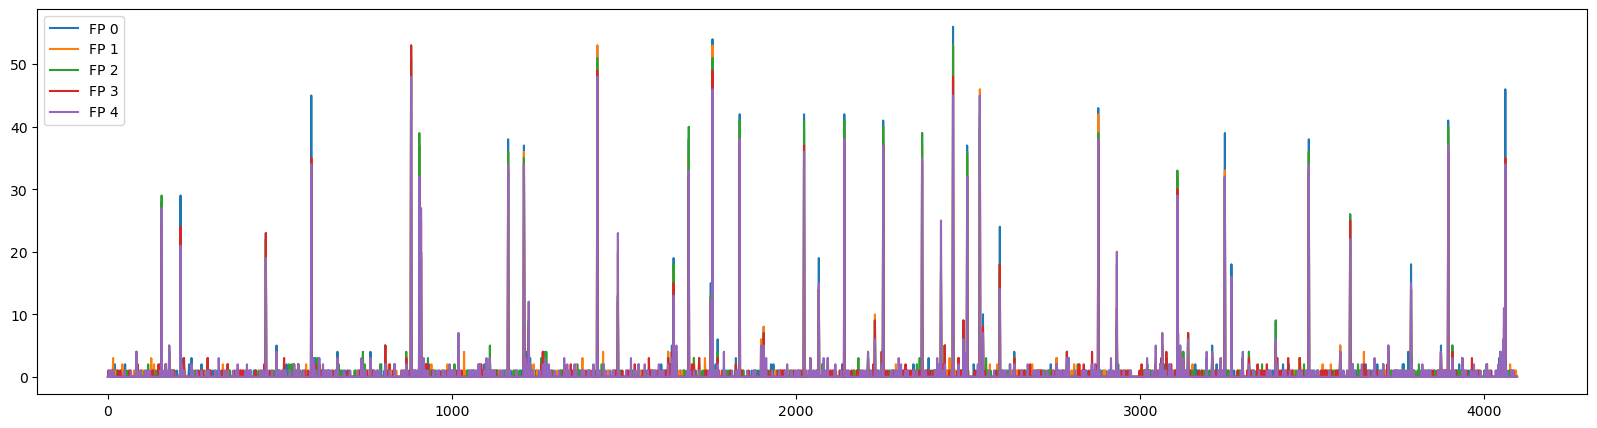

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))

for i, entry in enumerate(proj_obj.entries):
    fp = proj_obj.get_entry_results(entry).ifp
    plot_vals = [fp.counts[i] if i in fp.counts else 0 for i in range(1, fp.fp_length + 1)]
    ax.plot(plot_vals, label = f"FP {i}")
plt.legend()

#### Density - how populated is the fingerprint

(array([2., 0., 0., 0., 0., 1., 0., 1., 0., 1.]),
 array([0.11230469, 0.11452637, 0.11674805, 0.11896973, 0.12119141,
        0.12341309, 0.12563477, 0.12785645, 0.13007812, 0.1322998 ,
        0.13452148]),
 <BarContainer object of 10 artists>)

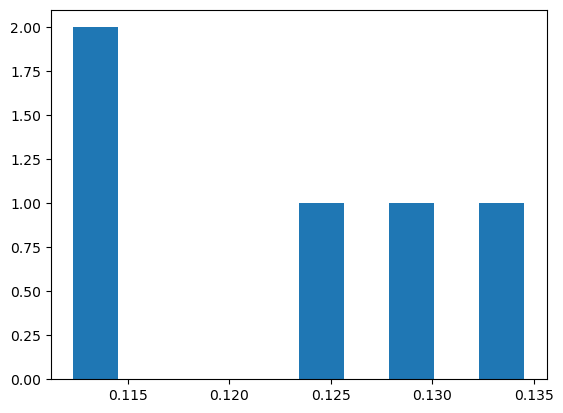

In [14]:
densities = [proj_obj.get_entry_results(entry).ifp.density for entry in proj_obj.entries]
plt.hist(densities)

#### Tanimoto coefficient - how similar are two fingerprints

You can calculate the similarity between two fingerprints using the function **calc_similarity()** from the fingerprint object.

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.21026895, 0.21145049, 0.21263203, 0.21381357, 0.21499512,
        0.21617666, 0.2173582 , 0.21853974, 0.21972128, 0.22090283,
        0.22208437]),
 <BarContainer object of 10 artists>)

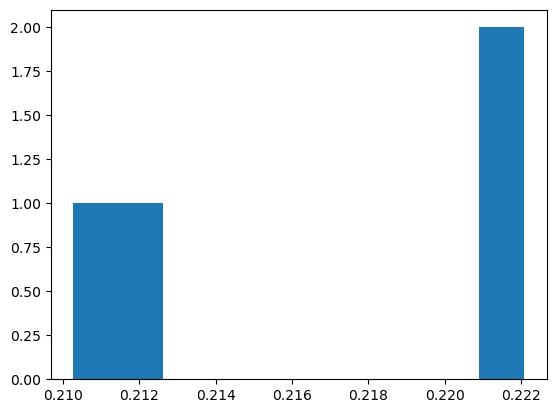

In [15]:
# Get a list of tuples where the first element is an entry and the second is an IFP.
ifps = list(proj_obj.ifps)

tanimotos = [ifps[0][1].calc_similarity(ifps[i][1]) for i in range(1,5)]

plt.hist(tanimotos)

## Export shells to Pymol sessions

To export shells to Pymol, you first need to create a **ShellGenerator** object that create shells for a given entry. As a result, it produces a **ShellManager** object. With a ShellManager you can access the created shells, create fingerprints, and trace back bit positions at a fingerprint back to its original shell.

In [16]:
from luna.interaction.fp.shell import ShellGenerator
from luna.interaction.fp.view import ShellViewer

In [17]:
target_entry = proj_obj.entries[0]
agm = proj_obj.get_entry_results(target_entry).atm_grps_mngr

sg = ShellGenerator(proj_obj.ifp_num_levels, proj_obj.ifp_radius_step, diff_comp_classes=proj_obj.ifp_diff_comp_classes, ifp_type=proj_obj.ifp_type)
sm = sg.create_shells(agm)

print("# shells: ", len(sm.shells))

# shells:  1984


In [18]:
psv = ShellViewer(add_directional_arrows=False)

# Let's select some shells. In this example, we are selecting only unique shells at level 4.
shells = sm.get_shells_by_level(4, unique_shells=True)
print("# shells at level 4: ", len(shells))

# Create a list of tuples, where the first item is the entry and the second item is the shells you want to visualize.
# In this example, let's visualize just the first six selected shells.
shell_tuples = [(target_entry, shells[0:6], proj_obj.pdb_path)]

# Define the output file. Note that all shells will be saved at the same Pymol session.
pse_file = "./outputs/shells_at_level4.pse"
psv.new_session(shell_tuples, pse_file)

# shells at level 4:  70
 Using Python 2 compatible legacy pickler
 Applying pse_export_version=1.800 compatibility


## Trace back a feature to its shell

To trace a feature in the fingerprint back to its shell, you need to use the function **trace_back_feature()** available at ShellManager objects.

In [21]:
ifp = sm.to_fingerprint(fold_to_length=4096, unique_shells=True, count_fp=False)

# Trace back the first feature set ON in the fingerprint.
recoved_shells = sm.trace_back_feature(ifp.get_on_bits()[0], ifp)

# As collisions may occur in a fingerprint, the trace_back_feature returns all shells collided in a given feature id.
for ori_feature, found_shells in recoved_shells:
    print("Shell id: %s" % ori_feature)
    print("  - Number of shells containing this id: %d." % len(found_shells))
    print()

Shell id: 3672809493
  - Number of shells containing this id: 1.

Shell id: 2117599253
  - Number of shells containing this id: 1.

